## Imports

In [33]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, classification_report, make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, train_test_split, ValidationCurveDisplay, validation_curve
#from sklearn.multioutput import MultiOutputRegressor

dir_parts = os.getcwd().split(os.path.sep)
root_index = dir_parts.index('ML-B-main')
root_path = os.path.sep.join(dir_parts[:root_index + 1])
sys.path.append(root_path + '/code/')
from data.data_config import Dataset
from data.data_utils import load_monk, load_cup, store_monk_result, store_cup_result
from hyperparameter_tuning import grid_search_top_configs
from training.metrics import mean_euclidean_error

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# SVM
In this notebook we test a **SVC** and a **SVR** w.r.t. the tasks at hand, i.e. the three MONK's problems and the CUP dataset respectively.

In [11]:
MODEL_NAME = 'SVM'

## Path

In [12]:
# Directories
results_dir = root_path + '/results/' + MODEL_NAME

# Filepaths (MONK)
m1_dev_path, m1_test_path = Dataset.MONK_1.dev_path, Dataset.MONK_1.test_path # MONK 1
m2_dev_path, m2_test_path = Dataset.MONK_2.dev_path, Dataset.MONK_2.test_path # MONK 2
m3_dev_path, m3_test_path = Dataset.MONK_3.dev_path, Dataset.MONK_3.test_path # MONK 3

# Filepaths (CUP)
cup_dev_path, cup_test_path = Dataset.CUP.dev_path, Dataset.CUP.test_path

# MONK-1

In [32]:
# Load MONK-1
x_dev_m1, y_dev_m1, x_test_m1, y_test_m1 = load_monk(m1_dev_path, m1_test_path)

First of all, we define the grid search spaces for the SVC that we're going to use for all three MONK's problems.

In [33]:
# hparams grid for grid search
#C=np.logspace(-2, 2, 5)
#gamma=np.logspace(-9, 3, 13)
clf_hparams_spaces = [
    {"kernel": ["rbf"], "gamma": [1e-4, 1e-3, 1e-2, 0.1, 'scale', 'auto'], "C": [0.01, 0.1, 1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
    {"kernel": ["poly"], "degree": [2,3,4,5], "gamma": [1e-4, 1e-3, 1e-2, 0.1, 'scale', 'auto'], "C": [0.01, 0.1, 1, 10, 100, 1000], "coef0": [0.0]}
]

## Grid search
Grid search is a simple hyper-parameter tuning techniques useful for finding the best configuration for a specific ML model. It involves:
- defining a grid of hparams values
- systematically test all possible combinations


In [61]:
# perform grid search with KFold

grid_search_m1 = GridSearchCV(
    SVC(),
    param_grid=clf_hparams_spaces,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=128),
    scoring='accuracy',
    verbose=1
)

grid_search_m1.fit(x_dev_m1, y_dev_m1)


Fitting 5 folds for each of 184 candidates, totalling 920 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=128, shuffle=True),
             estimator=SVC(),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100, 1000],
                          'gamma': [0.0001, 0.001, 0.01, 0.1, 'scale', 'auto'],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [0.01, 0.1, 1, 10, 100, 1000], 'coef0': [0.0],
                          'degree': [2, 3, 4, 5],
                          'gamma': [0.0001, 0.001, 0.01, 0.1, 'scale', 'auto'],
                          'kernel': ['poly']}],
             scoring='accuracy', verbose=1)

In [62]:
best_configs_m1, candidates_m1 = grid_search_top_configs(grid_search_m1.cv_results_) # top k config

Model rank 1 - Config: {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
Mean score 1.0000 - Std score: 0.0000

Model rank 2 - Config: {'C': 10, 'coef0': 0.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Mean score 1.0000 - Std score: 0.0000

Model rank 3 - Config: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Mean score 1.0000 - Std score: 0.0000

Model rank 4 - Config: {'C': 100, 'coef0': 0.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}
Mean score 1.0000 - Std score: 0.0000

Model rank 5 - Config: {'C': 100, 'coef0': 0.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Mean score 1.0000 - Std score: 0.0000



In [63]:
# Create a SVC with the best hparams
#clf = SVC(**grid_search_m1.best_params_)
clf = SVC(**grid_search_cup.cv_results_['params'][candidates_m1[2]]) #Uses different model rank (candidates[1] = best_params_)

# Train the model
clf.fit(x_dev_m1, y_dev_m1)


SVC(C=100, gamma='auto')

In [64]:
print('-- DEVELOPMENT --')
print(classification_report(y_dev_m1, clf.predict(x_dev_m1)))
accuracy_dev_m1 = accuracy_score(y_dev_m1, clf.predict(x_dev_m1))
mse_dev_m1 = mean_squared_error(y_dev_m1, clf.predict(x_dev_m1))
print(f"Accuracy_dev = {accuracy_dev_m1:.2f}")
print(f"MSE_dev = {mse_dev_m1:.4f}")

-- DEVELOPMENT --
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        62

    accuracy                           1.00       124
   macro avg       1.00      1.00      1.00       124
weighted avg       1.00      1.00      1.00       124

Accuracy_dev = 1.00
MSE_dev = 0.0000


- **Precision** is the ability of the classifier not to label as positive a sample that is negative:
=> Precision = True Positive / (True Positive + False Positive)

- **Recall** (or sensitivity) is the ability of the classifier to find all the positive samples:
=> Recall = True Positive / (True Positive + False Negative)

**Precision VS Recall**
- Use precision when the cost of false positives is high: In situations where misclassifying an instance as positive has serious consequences, precision is a better choice. For example, in medical diagnosis.
- Use recall when the cost of false negatives is high: When the consequence of misclassifying an instance as negative is severe, recall is a better choice. For example, in fraud detection.

The **F1 score** is the harmonic mean of the precision and recall. It thus symmetrically represents both precision and recall in one metric (F1 score gives equal importance to precision and recall)
=> F1 = (Precision * Recall) / (Precision + Recall)

In [65]:
print('-- TEST --')
report_test_m1 = classification_report(y_test_m1, clf.predict(x_test_m1))
print(report_test_m1)
accuracy_test_m1 = accuracy_score(y_test_m1, clf.predict(x_test_m1))
mse_test_m1 = mean_squared_error(y_test_m1, clf.predict(x_test_m1))
print(f"Accuracy_test = {accuracy_test_m1:.2f}")
print(f"MSE_test = {mse_test_m1:.4f}")

-- TEST --
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       216
           1       1.00      1.00      1.00       216

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432

Accuracy_test = 1.00
MSE_test = 0.0000


## Store results

In [66]:
store_monk_result(results_dir + '/MONK1/', best_configs_m1, report_test_m1)

# MONK-2

In [67]:
# Load MONK-2
x_dev_m2, y_dev_m2, x_test_m2, y_test_m2 = load_monk(m2_dev_path, m2_test_path)

In [68]:
# perform grid search with KFold
grid_search_m2 = GridSearchCV(
    SVC(),
    param_grid=clf_hparams_spaces,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=128),
    scoring='accuracy',
    verbose=1
)

grid_search_m2.fit(x_dev_m2, y_dev_m2)

Fitting 5 folds for each of 184 candidates, totalling 920 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=128, shuffle=True),
             estimator=SVC(),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100, 1000],
                          'gamma': [0.0001, 0.001, 0.01, 0.1, 'scale', 'auto'],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [0.01, 0.1, 1, 10, 100, 1000], 'coef0': [0.0],
                          'degree': [2, 3, 4, 5],
                          'gamma': [0.0001, 0.001, 0.01, 0.1, 'scale', 'auto'],
                          'kernel': ['poly']}],
             scoring='accuracy', verbose=1)

In [69]:
best_configs_m2, candidates_m2 = grid_search_top_configs(grid_search_m2.cv_results_) # top k config

Model rank 1 - Config: {'C': 100, 'coef0': 0.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Mean score 0.9342 - Std score: 0.0723

Model rank 2 - Config: {'C': 1000, 'coef0': 0.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}
Mean score 0.9342 - Std score: 0.0723

Model rank 3 - Config: {'C': 1000, 'coef0': 0.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Mean score 0.9342 - Std score: 0.0723

Model rank 4 - Config: {'C': 1000, 'coef0': 0.0, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
Mean score 0.9342 - Std score: 0.0723

Model rank 5 - Config: {'C': 100, 'coef0': 0.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}
Mean score 0.8219 - Std score: 0.1144



In [70]:
# Create a SVC with the best hparams
clf = SVC(**grid_search_m2.best_params_)
#clf = SVC(**grid_search_cup.cv_results_['params'][candidates_m2[4]])

# Train the model
clf.fit(x_dev_m2, y_dev_m2)

SVC(C=100, degree=2, kernel='poly')

In [71]:
print('-- DEVELOPMENT --')
print(classification_report(y_dev_m2, clf.predict(x_dev_m2)))
accuracy_dev_m2 = accuracy_score(y_dev_m2, clf.predict(x_dev_m2))
mse_dev_m2 = mean_squared_error(y_dev_m2, clf.predict(x_dev_m2))
print(f"Accuracy_dev = {accuracy_dev_m2:.2f}")
print(f"MSE_dev = {mse_dev_m2:.4f}")

-- DEVELOPMENT --
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       1.00      1.00      1.00        64

    accuracy                           1.00       169
   macro avg       1.00      1.00      1.00       169
weighted avg       1.00      1.00      1.00       169

Accuracy_dev = 1.00
MSE_dev = 0.0000


In [72]:
print('-- TEST --')
report_test_m2 = classification_report(y_test_m2, clf.predict(x_test_m2))
print(report_test_m2)
accuracy_test_m2 = accuracy_score(y_test_m2, clf.predict(x_test_m2))
mse_test_m2 = mean_squared_error(y_test_m2, clf.predict(x_test_m2))
print(f"Accuracy_test = {accuracy_test_m2:.2f}")
print(f"MSE_test = {mse_test_m2:.4f}")

-- TEST --
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       290
           1       1.00      1.00      1.00       142

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432

Accuracy_test = 1.00
MSE_test = 0.0000


In [73]:
store_monk_result(results_dir + '/MONK2/', best_configs_m2, report_test_m2)

# MONK-3

In [74]:
# Load MONK-3
x_dev_m3, y_dev_m3, x_test_m3, y_test_m3 = load_monk(m3_dev_path, m3_test_path)

In [75]:
# perform grid search with KFold
grid_search_m3 = GridSearchCV(
    SVC(),
    param_grid=clf_hparams_spaces,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=128),
    scoring='accuracy',
    verbose=1
)

grid_search_m3.fit(x_dev_m3, y_dev_m3)

Fitting 5 folds for each of 184 candidates, totalling 920 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=128, shuffle=True),
             estimator=SVC(),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100, 1000],
                          'gamma': [0.0001, 0.001, 0.01, 0.1, 'scale', 'auto'],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [0.01, 0.1, 1, 10, 100, 1000], 'coef0': [0.0],
                          'degree': [2, 3, 4, 5],
                          'gamma': [0.0001, 0.001, 0.01, 0.1, 'scale', 'auto'],
                          'kernel': ['poly']}],
             scoring='accuracy', verbose=1)

In [76]:
best_configs_m3, candidates_m3 = grid_search_top_configs(grid_search_m3.cv_results_) # top k config

Model rank 1 - Config: {'C': 10, 'kernel': 'linear'}
Mean score 0.9353 - Std score: 0.0477

Model rank 2 - Config: {'C': 100, 'kernel': 'linear'}
Mean score 0.9353 - Std score: 0.0477

Model rank 3 - Config: {'C': 1000, 'kernel': 'linear'}
Mean score 0.9353 - Std score: 0.0477

Model rank 4 - Config: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
Mean score 0.9353 - Std score: 0.0477

Model rank 5 - Config: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
Mean score 0.9353 - Std score: 0.0477



In [77]:
# Create a SVC with the best hparams
clf = SVC(**grid_search_m3.best_params_)
#clf = SVC(**grid_search_cup.cv_results_['params'][candidates_m3[4]])

# Train the model
clf.fit(x_dev_m3, y_dev_m3)

SVC(C=1, gamma=0.1)

In [78]:
print('-- DEVELOPMENT --')
print(classification_report(y_dev_m3, clf.predict(x_dev_m3)))
accuracy_dev_m3 = accuracy_score(y_dev_m3, clf.predict(x_dev_m3))
mse_dev_m3 = mean_squared_error(y_dev_m3, clf.predict(x_dev_m3))
print(f"Accuracy_dev = {accuracy_dev_m3:.2f}")
print(f"MSE_dev = {mse_dev_m3:.4f}")

-- DEVELOPMENT --
              precision    recall  f1-score   support

           0       0.95      0.92      0.93        62
           1       0.92      0.95      0.93        60

    accuracy                           0.93       122
   macro avg       0.93      0.93      0.93       122
weighted avg       0.93      0.93      0.93       122

Accuracy_dev = 0.93
MSE_dev = 0.0278


In [79]:
print('-- TEST --')
report_test_m3 = classification_report(y_test_m3, clf.predict(x_test_m3))
print(report_test_m3)
accuracy_test_m3 = accuracy_score(y_test_m3, clf.predict(x_test_m3))
mse_test_m3 = mean_squared_error(y_test_m3, clf.predict(x_test_m3))
print(f"Accuracy_test = {accuracy_test_m3:.2f}")
print(f"MSE_test = {mse_test_m3:.4f}")

-- TEST --
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       204
           1       1.00      0.95      0.97       228

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432

Accuracy_test = 0.97
MSE_test = 0.0278


In [80]:
store_monk_result(results_dir + '/MONK3/', best_configs_m3, report_test_m3)

# CUP

In [13]:
# Load CUP
x_dev_cup, y_dev_cup, x_test_cup = load_cup(cup_dev_path, cup_test_path)

In [14]:
# Split data for internal test
x_train_cup, x_intest_cup, y_train_cup, y_intest_cup = train_test_split(x_dev_cup, y_dev_cup, test_size=0.1, random_state=128)

In [15]:
# SVR models can produce only one output, so the three columns of the output are separated
y_train_cup1, y_train_cup2, y_train_cup3 = np.hsplit(y_train_cup, 3)
y_intest_cup1, y_intest_cup2, y_intest_cup3 = np.hsplit(y_intest_cup, 3)
y_dev_cup1, y_dev_cup2, y_dev_cup3 = np.hsplit(y_dev_cup, 3)

# Targets must be of the form (n° samples, )
y_train_cup1 = np.ravel(y_train_cup1)
y_train_cup2 = np.ravel(y_train_cup2)
y_train_cup3 = np.ravel(y_train_cup3)
y_intest_cup1 = np.ravel(y_intest_cup1)
y_intest_cup2 = np.ravel(y_intest_cup2)
y_intest_cup3 = np.ravel(y_intest_cup3)
y_dev_cup1 = np.ravel(y_dev_cup1)
y_dev_cup2 = np.ravel(y_dev_cup2)
y_dev_cup3 = np.ravel(y_dev_cup3)

# Hyperparameters tuning
Here, we define the grid search spaces for the SVR for the CUP dataset.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   23.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   20.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.8s finished


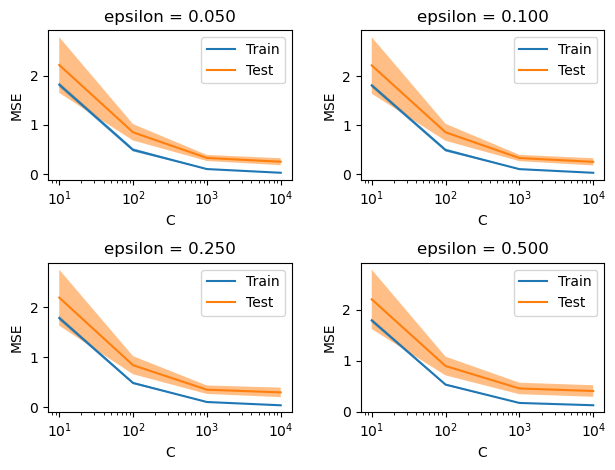

min_train_scores = [-0.0238, -0.0249, -0.0422, -0.1225]
min_test_scores = [-0.1749, -0.1539, -0.1888, -0.2777]


In [9]:
# Validation curves
param_name = "C"
param_range = np.logspace(1, 4, 4)
figure, axis = plt.subplots(2, 2)
min_train_scores=[]
min_test_scores=[]

for (epsilon, i, j) in zip(np.logspace(-3, 0, 4), [0,0,1,1], [0,1,0,1]):
    train_scores, test_scores = validation_curve(SVR(kernel='rbf', gamma = 'scale', epsilon=epsilon, cache_size=200), 
                                          x_train_cup, 
                                          y_train_cup1, 
                                          param_name=param_name, 
                                          param_range=param_range,
                                          cv=KFold(n_splits=5, shuffle=True, random_state=128),
                                          scoring= 'neg_mean_squared_error',
                                          n_jobs=-1,
                                          verbose=1)
    
    min_train_scores.append(round(np.max(train_scores),4)) #score is negative
    min_test_scores.append(round(np.max(test_scores),4)) 
                                          
    display = ValidationCurveDisplay(param_name=param_name, 
                                     param_range=param_range,
                                     train_scores=train_scores, 
                                     test_scores=test_scores,
                                     score_name="MSE")
    display.plot(ax=axis[i,j], negate_score = True)
    axis[i,j].set_title('epsilon = %1.3f' %epsilon)

figure.tight_layout()
plt.show()
print(f"min_train_scores = {min_train_scores}")
print(f"min_test_scores = {min_test_scores}")

In [ ]:
#hparams grid for grid search

#The top 5 consists only of rbf kernels in all three SVR models, to speed up the grind search the other kernels are excluded
"""
regr_hparams_spaces = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4, 'scale', 'auto'], "C": [0.01, 0.1, 1, 10, 100, 1000], "epsilon" : [1e-3, 1e-2, 0.1, 1.0]},
    {"kernel": ["linear"], "C": [0.01, 0.1, 1, 1, 10, 100, 1000], "epsilon" : [1e-3, 1e-2, 0.1, 1.0]},
    {"kernel": ["poly"], "degree": [2,3,4], "gamma": [1e-3, 1e-4, 'scale', 'auto'], "coef0": [0.0], "C": [0.01, 0.1, 1, 10, 100, 1000], "epsilon" : [1e-3, 1e-2, 0.1, 1.0]}
]"""

In [17]:
regr_hparams_spaces = {"kernel": ["rbf"], "gamma": ['scale', 'auto'], "C": [1e3, 1.5e3, 2e3, 2.5e3, 3e3], "epsilon" : [0.05, 0.1, 0.25, 0.5]}

- The **gamma** parameter in rbf defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The gamma parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.
- The **C** parameter trades off correct classification of training examples against maximization of the decision function’s margin. Large values of C implies a small margin, a lower C will encourage a larger margin. In other words C behaves as a regularization parameter in the SVM.
- **poly** = $( \; gamma \;\; * <x,y> \; + \; coef0 \;)^{degree}$
- **epsilon** specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value. Must be non-negative.

## Grid search

In [37]:
# perform grid search with KFold
# Increased the cache to decrease the tarining time (from 200 to 1000 MB)
# Use n_jobs = number of jobs to run in parallel. -1 means using all processors
# scoring=make_scorer(mean_euclidean_error, greater_is_better=False)
grid_search_cup = GridSearchCV(
    SVR(cache_size=1000),
    param_grid=regr_hparams_spaces,
    cv=KFold(n_splits=5, shuffle=True, random_state=128),
    scoring= 'neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search_cup.fit(x_train_cup, y_train_cup1)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=128, shuffle=True),
             estimator=SVR(cache_size=1000), n_jobs=-1,
             param_grid={'C': [1000.0, 1500.0, 2000.0, 2500.0, 3000.0],
                         'epsilon': [0.05, 0.1, 0.25, 0.5],
                         'gamma': ['scale', 'auto'], 'kernel': ['rbf']},
             scoring='neg_mean_squared_error', verbose=1)

In [38]:
print('--OUTPUT 1--')
best_configs_cup1, candidates1 = grid_search_top_configs(grid_search_cup.cv_results_) # top k config

--OUTPUT 1--
Model rank 1 - Config: {'C': 2500.0, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean score -0.2407 - Std score: 0.0698

Model rank 2 - Config: {'C': 3000.0, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean score -0.2416 - Std score: 0.0703

Model rank 3 - Config: {'C': 2000.0, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean score -0.2433 - Std score: 0.0697

Model rank 4 - Config: {'C': 2500.0, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'rbf'}
Mean score -0.2446 - Std score: 0.0660

Model rank 5 - Config: {'C': 3000.0, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'rbf'}
Mean score -0.2470 - Std score: 0.0700



In [39]:
# Create a SVR with the best hparams
rfr1 = SVR(**grid_search_cup.best_params_)
#rfr1 = SVR(**grid_search_cup.cv_results_['params'][candidates1[4]])

# Train the model
rfr1.fit(x_train_cup, y_train_cup1)

SVR(C=2500.0)

In [40]:
grid_search_cup.fit(x_train_cup, y_train_cup2)
print('--OUTPUT 2--')
best_configs_cup2, candidates2 = grid_search_top_configs(grid_search_cup.cv_results_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
--OUTPUT 2--
Model rank 1 - Config: {'C': 3000.0, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'rbf'}
Mean score -0.2498 - Std score: 0.0555

Model rank 2 - Config: {'C': 3000.0, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean score -0.2537 - Std score: 0.0541

Model rank 3 - Config: {'C': 2500.0, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'rbf'}
Mean score -0.2540 - Std score: 0.0547

Model rank 4 - Config: {'C': 2000.0, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean score -0.2567 - Std score: 0.0475

Model rank 5 - Config: {'C': 2000.0, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'rbf'}
Mean score -0.2569 - Std score: 0.0526



In [44]:
#rfr2 = SVR(**grid_search_cup.best_params_)
rfr2 = SVR(**grid_search_cup.cv_results_['params'][candidates2[3]]) #Uses different model rank (candidates[1] = best_params_)

rfr2.fit(x_train_cup, y_train_cup2)

SVR(C=2000.0)

In [45]:
grid_search_cup.fit(x_train_cup, y_train_cup3)
print('--OUTPUT 3--')
best_configs_cup3, candidates3 = grid_search_top_configs(grid_search_cup.cv_results_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
--OUTPUT 3--
Model rank 1 - Config: {'C': 3000.0, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'rbf'}
Mean score -0.1107 - Std score: 0.0288

Model rank 2 - Config: {'C': 2500.0, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'rbf'}
Mean score -0.1116 - Std score: 0.0297

Model rank 3 - Config: {'C': 2000.0, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'rbf'}
Mean score -0.1125 - Std score: 0.0299

Model rank 4 - Config: {'C': 1500.0, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean score -0.1131 - Std score: 0.0269

Model rank 5 - Config: {'C': 1000.0, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean score -0.1142 - Std score: 0.0280



In [46]:
#rfr3 = SVR(**grid_search_cup.best_params_)
rfr3 = SVR(**grid_search_cup.cv_results_['params'][candidates3[4]])

rfr3.fit(x_train_cup, y_train_cup3)

SVR(C=1000.0)

In [47]:
print('-- DEVELOPMENT 1 --')
y_preds_up1 = rfr1.predict(x_train_cup)
dev_mee_cup1 = mean_euclidean_error(y_train_cup1, y_preds_up1)
print(dev_mee_cup1)

print('\n-- DEVELOPMENT 2 --')
y_preds_up2 = rfr2.predict(x_train_cup)
dev_mee_cup2 = mean_euclidean_error(y_train_cup2, y_preds_up2)
print(dev_mee_cup2)

print('\n-- DEVELOPMENT 3 --')
y_preds_up3 = rfr3.predict(x_train_cup)
dev_mee_cup3 = mean_euclidean_error(y_train_cup3, y_preds_up3)
print(dev_mee_cup3)

-- DEVELOPMENT 1 --
4.620079547197506

-- DEVELOPMENT 2 --
5.05607714129837

-- DEVELOPMENT 3 --
3.9259491745266453


In [48]:
print('--INTERNAL TEST 1--')
y_inpreds_up1 = rfr1.predict(x_intest_cup)
intest_mee_cup1 = mean_euclidean_error(y_intest_cup1, y_inpreds_up1)
print(intest_mee_cup1)

print('\n--INTERNAL TEST 2--')
y_inpreds_up2 = rfr2.predict(x_intest_cup)
intest_mee_cup2 = mean_euclidean_error(y_intest_cup2, y_inpreds_up2)
print(intest_mee_cup2)

print('\n--INTERNAL TEST 3--')
y_inpreds_up3 = rfr3.predict(x_intest_cup)
intest_mee_cup3 = mean_euclidean_error(y_intest_cup3, y_inpreds_up3)
print(intest_mee_cup3)

intest_mee_cup = np.mean([intest_mee_cup1, intest_mee_cup2, intest_mee_cup3])
print(f"\nInternal test mee = {intest_mee_cup:.4f}")

--INTERNAL TEST 1--
7.640829281794288

--INTERNAL TEST 2--
8.211616395875541

--INTERNAL TEST 3--
4.857313064052491

Internal test mee = 6.9033


In [49]:
print('-- RETRAINING 1--')
rfr1.fit(x_dev_cup, y_dev_cup1)
y_preds_up1 = rfr1.predict(x_dev_cup)
dev_mee_cup1 = mean_euclidean_error(y_dev_cup1, y_preds_up1)
print(dev_mee_cup1)

print('\n-- RETRAINING 2--')
rfr2.fit(x_dev_cup, y_dev_cup2)
y_preds_up2 = rfr2.predict(x_dev_cup)
dev_mee_cup2 = mean_euclidean_error(y_dev_cup2, y_preds_up2)
print(dev_mee_cup2)

print('\n-- RETRAINING 3--')
rfr3.fit(x_dev_cup, y_dev_cup3)
y_preds_up3 = rfr3.predict(x_dev_cup)
dev_mee_cup3 = mean_euclidean_error(y_dev_cup3, y_preds_up3)
print(dev_mee_cup3)

dev_mee_cup = np.mean([dev_mee_cup1, dev_mee_cup2, dev_mee_cup3])
print(f"\nRetraining mee = {dev_mee_cup:.4f}")

-- RETRAINING 1--
5.290958171364963

-- RETRAINING 2--
5.6377969463709565

-- RETRAINING 3--
4.447134423172176

Retraining mee = 5.1253


In [50]:
# Blind test set predictions
test_preds_cup = [rfr1.predict(x_test_cup), rfr2.predict(x_test_cup), rfr3.predict(x_test_cup)]

## Store Result

In [51]:
store_cup_result(results_dir + '/CUP/', best_configs_cup1, 1, dev_mee_cup, intest_mee_cup, test_preds_cup)
store_cup_result(results_dir + '/CUP/', best_configs_cup2, 2, dev_mee_cup, intest_mee_cup, test_preds_cup)
store_cup_result(results_dir + '/CUP/', best_configs_cup3, 3, dev_mee_cup, intest_mee_cup, test_preds_cup)